# CAVI vs CAVI-EB vs SVI vs SVI-EB Sparse pCMF

In [1]:
from pCMF.misc import utils
from pCMF.models.pcmf import cavi_spcmf, svi_spcmf

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

from scipy.stats import gamma

import operator
import seaborn as sns
sns.set_style('whitegrid')

# plt.style.use('ggplot')

In [2]:
T = 60.
S = 1.

In [3]:
# Experiment parameters
N = 1000 # number of observations
P = 20 # observation space dimensionality
K = 10 # latent space dimensionality
C = 2 # number of clusters

# Generate data set
z_p = 0.5
eps = 5.
Y, D, X, R, V, U, clusters = utils.generate_sparse_data(N, P, K, C=C, zero_prob=z_p, noisy_prop=0.5,
                                                 eps_U=eps, return_all=True)

Y_train, Y_test, U_train, U_test, c_train, c_test = train_test_split(Y, U.T, clusters, test_size=0.2, random_state=42)

In [4]:
# Run PCA
pca_U = PCA(n_components=K).fit_transform(np.log(Y_train + 1.))
pca_pca = TSNE(n_components=2).fit_transform(pca_U)

In [5]:
# Run CAVI and get estimates (SpCMF)
alpha = np.ones((2, K))
alpha[0, :] = 3.
alpha[1, :] = 0.5
beta = np.ones((2, P, K))
pi_D = np.ones((P,)) * 0.5
pi_S = np.ones((P,)) * 0.5
print('PCMF:')
infspcmf = cavi_spcmf.CoordinateAscentVI(Y_train, alpha, beta, pi_D, pi_S)
spcmf_ll = infspcmf.run_cavi(n_iterations=4000, empirical_bayes=False, return_ll=True, sampling_rate=S, max_time=T)
spcmf_U = infspcmf.a[0] / infspcmf.a[1] # VI estimate is the mean of the variational approximation
spcmf_pca = TSNE(n_components=2).fit_transform(spcmf_U)

PCMF:


In [6]:
# Run CAVI and get estimates (SpCMF)
alpha = np.ones((2, K))
alpha[0, :] = 3.
alpha[1, :] = 0.5
beta = np.ones((2, P, K))
pi_D = np.ones((P,)) * 0.5
pi_S = np.ones((P,)) * 0.5
print('PCMF:')
infspcmfeb = cavi_spcmf.CoordinateAscentVI(Y_train, alpha, beta, pi_D, pi_S)
spcmfeb_ll = infspcmfeb.run_cavi(n_iterations=4000, empirical_bayes=True, return_ll=True, sampling_rate=S, max_time=T)
spcmfeb_U = infspcmfeb.a[0] / infspcmfeb.a[1] # VI estimate is the mean of the variational approximation
spcmfeb_pca = TSNE(n_components=2).fit_transform(spcmfeb_U)

PCMF:


In [7]:
# Run SVI and get estimates (pCMF)
alpha = np.ones((2, K))
alpha[0, :] = 3.
alpha[1, :] = 0.5
beta = np.ones((2, P, K))
pi_D = np.ones((P,)) * 0.5
pi_S = np.ones((P,)) * 0.5
print('Stochastic PCMF:')
infspcmfsvi = svi_spcmf.StochasticVI(Y_train, alpha, beta, pi_D, pi_S)
spcmfsvi_ll = infspcmfsvi.run_svi(n_iterations=4000, minibatch_size=100, empirical_bayes=False, return_ll=True, sampling_rate=S, max_time=T)
spcmfsvi_U = infspcmfsvi.a[0] / infspcmfsvi.a[1] # VI estimate is the mean of the variational approximation
spcmfsvi_pca = TSNE(n_components=2).fit_transform(spcmfsvi_U)

Stochastic PCMF:


In [8]:
# Run SVI and get estimates (pCMF)
alpha = np.ones((2, K))
alpha[0, :] = 3.
alpha[1, :] = 0.5
beta = np.ones((2, P, K))
pi_D = np.ones((P,)) * 0.5
pi_S = np.ones((P,)) * 0.5
print('Stochastic PCMF:')
infspcmfsvieb = svi_spcmf.StochasticVI(Y_train, alpha, beta, pi_D, pi_S)
spcmfsvieb_ll = infspcmfsvi.run_svi(n_iterations=4000, minibatch_size=100, empirical_bayes=True, return_ll=True, sampling_rate=S, max_time=T)
spcmfsvieb_U = infspcmfsvieb.a[0] / infspcmfsvieb.a[1] # VI estimate is the mean of the variational approximation
spcmfsvieb_pca = TSNE(n_components=2).fit_transform(spcmfsvieb_U)

Stochastic PCMF:


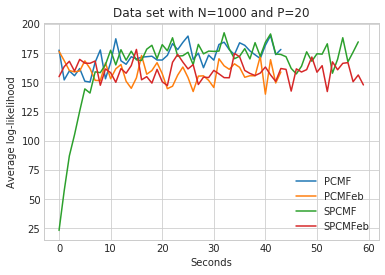

In [9]:
plt.plot(spcmf_ll[1], label='PCMF')
plt.plot(spcmfeb_ll[1], label='PCMFeb')
plt.plot(spcmfsvi_ll[1], label='SPCMF')
plt.plot(spcmfsvieb_ll[1], label='SPCMFeb')
plt.ylabel('Average log-likelihood')
plt.xlabel('Seconds')
plt.title('Data set with N={} and P={}'.format(N, P))
plt.legend()
plt.show()

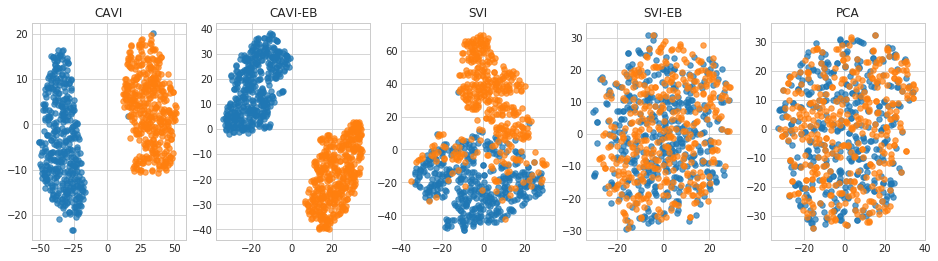

In [10]:
U_list = [spcmf_pca, spcmfeb_pca, spcmfsvi_pca, spcmfsvieb_pca, pca_pca]
title_list = ['CAVI', 'CAVI-EB', 'SVI', 'SVI-EB', 'PCA']

n_results = len(U_list)

assert len(U_list) == len(title_list)

fig = plt.figure(figsize=(16, 4))

s = 30
alpha = 0.7
labels=None
for i in range(len(U_list)):
    ax = plt.subplot(1, n_results, i+1)
    handlers = []
    for c in range(C):
        h = ax.scatter(U_list[i][c_train==c, 0], U_list[i][c_train==c, 1], s=s, alpha=alpha)
        handlers.append(h)
    if labels is not None:
        ax.legend(handlers, labels, scatterpoints=1)
    plt.title(title_list[i])
plt.show()

In [16]:
true_silh = silhouette_score(U_train, c_train)
spcmf_silh = silhouette_score(spcmf_U, c_train)
spcmfeb_silh = silhouette_score(spcmfeb_U, c_train)
spcmfsvi_silh = silhouette_score(spcmfsvi_U, c_train)
spcmfsvieb_silh = silhouette_score(spcmfsvieb_U, c_train)
pca_silh = silhouette_score(pca_U, c_train)

scores = {'SVI': spcmfsvi_silh, 'CAVI-EB': spcmfeb_silh, 'SVI-EB': spcmfsvieb_silh, 'CAVI': spcmf_silh, 'PCA': pca_silh}

sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)

print('Silhouette scores (higher is better):')
print('\033[1m- {0}: {1:.3}\033[0m'.format(sorted_scores[0][0], sorted_scores[0][1]))
for score_tp in sorted_scores[1:]:
    print('- {0}: {1:.3}'.format(score_tp[0], score_tp[1]))
    
print('\nSilhouette of true U:')
print('%0.3f' % true_silh)

Silhouette scores (higher is better):
- CAVI-EB: 0.528
- CAVI: 0.441
- SVI: 0.162
- PCA: 0.00174
- SVI-EB: 0.000566

Silhouette of true U:
0.544


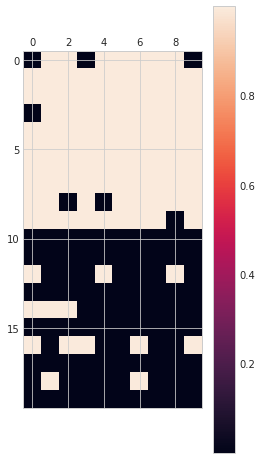

In [14]:
plt.matshow(infspcmfeb.p_S)
plt.colorbar()
plt.show()